In [55]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
sys.path.append("../../")
from AMDC import AMDC
import command_que as que
from Cramb_Control import CRAMB
import os

## Input

In [56]:
bus_voltage = 30     #set by DC power supply
inverter_num = 3

# ADC Gains

Each ADC channel has a scalar multiplier which converts raw voltage value into current. This value is unique to each channel and each hardware environment. This document calculates this value for each channel.

## Set Voltages on Each Phase

Initially I was going to use this code below to automatically set the voltages to the desired voltages. Unfortunately, as of right now I have no way of getting output back from the AMDC so I would not be able to read the ADC values after outputting the voltages.

In [57]:
N = 10               #number of data points
voltages = np.linspace(0, bus_voltage, N)  #pole voltages

###### CREATE COMMANDS AND INFO LIST ######
cmds = []
info = []

for i, volts in enumerate(voltages):

    #create command string
    cmd = (volts, i)
    cmds.append(cmd)

    #create info list
    info.append(f'Data Point {i+1}/{N}')
    

In [58]:
###### CREATE CLASS FOR EXECUTE FUNCTION ######        
class Execute():
    
    def __init__(self, N, cramb_obj):
        
        self.data = np.zeros( (N, 2) )
        self.cramb = cramb_obj
    
    def __call__(self, cmd, cmd_cnt):
        
        #output command and capture data
        volts, i = cmd #unpack tuple
        cramb.a_pole_volts(volts, 0)
        true_current = input('Enter True Current: ') #wait for user to input true current value
        self.data[i,1] = float(true_current)
        #read adc after immediately after current is read so true current matches time at which adc is read
        adc = cramb.a_read_adc()
        self.data[i,0] = adc
        
    def quit(self):
        self.cramb.a_zero()

In [59]:
def save_name(file_name):
    
    suffix = '.txt'
    cnt = 0
    while os.path.exists(file_name + suffix):
        cnt+=1
        suffix = '_' + f'{cnt}'.rjust(3, '0') + '.txt' 
        
    fname = file_name + suffix
    return fname    

In [60]:
port = "COM4"
amdc = AMDC(port, cmdEcho = False) #create amdc object
cramb = CRAMB(amdc) #create cramb object, which has an amdc
cramb.connect() #connect the serial communication

cramb.a_set_vdc(bus_voltage)
cramb.a_set_inverter(inverter_num)

ex = Execute(N, cramb)

ex = que.command_que(cmds = cmds, execute_obj = ex, info = info)
cramb.disconnect()

#save the data to a file
file_name = f"ADC_Gain_Data_INV{inverter_num}"
fname = save_name(file_name) #ensure that data is not overwritten by creating unique file names
np.savetxt(fname, ex.data, header = 'ADC, I_true')

####################  START  #####################
Info: Data Point 1/10
Current Command: (0.0, 0)



Enter a command:  e
Enter True Current:  .0000004


Executed
##################################################
Info: Data Point 2/10
Current Command: (3.3333333333333335, 1)



Enter a command:  e
Enter True Current:  .15525


Executed
##################################################
Info: Data Point 3/10
Current Command: (6.666666666666667, 2)



Enter a command:  e
Enter True Current:  .31099


Executed
##################################################
Info: Data Point 4/10
Current Command: (10.0, 3)



Enter a command:  e
Enter True Current:  .4669


Executed
##################################################
Info: Data Point 5/10
Current Command: (13.333333333333334, 4)



Enter a command:  e
Enter True Current:  .6227


Executed
##################################################
Info: Data Point 6/10
Current Command: (16.666666666666668, 5)



Enter a command:  e
Enter True Current:  .7783


Executed
##################################################
Info: Data Point 7/10
Current Command: (20.0, 6)



Enter a command:  e
Enter True Current:  .9330


Executed
##################################################
Info: Data Point 8/10
Current Command: (23.333333333333336, 7)



Enter a command:  e
Enter True Current:  1.0876


Executed
##################################################
Info: Data Point 9/10
Current Command: (26.666666666666668, 8)



Enter a command:  e
Enter True Current:  1.1333


Executed
#####################  End  ######################
Info: Data Point 10/10
Current Command: (30.0, 9)



Enter a command:  e
Enter True Current:  1.0100


Executed
#####################  End  ######################
Info: Data Point 10/10
Current Command: (30.0, 9)



Enter a command:  q


#####################  DONE  #####################

Done with all commands!



In [61]:
ex.data

array([[ 5.0000e-03,  4.0000e-07],
       [-3.0000e-01,  1.5525e-01],
       [-6.1250e-01,  3.1099e-01],
       [-9.2250e-01,  4.6690e-01],
       [-1.2350e+00,  6.2270e-01],
       [-1.5450e+00,  7.7830e-01],
       [-1.8575e+00,  9.3300e-01],
       [-2.1650e+00,  1.0876e+00],
       [-2.2600e+00,  1.1333e+00],
       [-2.0125e+00,  1.0100e+00]])

## Data

Data was collected by forcing a DC current through the LEM sensor on each channel. The raw ADC value was then read. The following is the collected data for all three phases (A, B, and C). Various currents are applied.

In [62]:
v_adc, i_true   = np.loadtxt(fname, skiprows = 1, unpack = True)

## Plot

The linearity of the data depends on the sensor measurement system (LEM sensors, analog front-end, ADCs, etc). The data are plotted below, showing indeed the system looks linear.

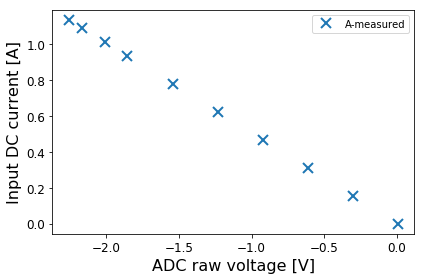

In [63]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("ADC raw voltage [V]", color = 'black', fontsize = 16)
ax.set_ylabel("Input DC current [A]", color = 'black', fontsize = 16)

ax.plot(v_adc, i_true, color = 'C0',   linestyle = '',  marker = 'x', markersize = 10, markeredgewidth = 2, label = 'A-measured')
ax.tick_params(labelsize = 12) #make tick labels larger

ax.legend(); #adding semicolon in jupyter notebook suppresses output. This is useful sometimes because last line of cell is automatically
             #printed even without print statement. (Try removing semicolon and rerunning the cell you will see the output of the legend call)
             #note that this is a feature of jupyter notebooks, NOT python. 

fig.tight_layout()
    
#note that in Jupyter notebook there is no need to call 'fig.show()'. Figures will display automatically because of the magic
#command ''%matplotlib inline' that was used at the beginning of this notebook

## Extracting ADC gains

The slope of the plotted line relates the input current through the sensor to the ADC raw voltage value.

We need the ADC $Gain$ for the following equation: $ Current = Gain * ADC\_Voltage + Offset$

Therefore, we apply a best fit linear line. Then, the inverse of the slope gives us the gain.

In [64]:
P = np.polyfit(v_adc, i_true, 1)

print(f'ADC Fit: I = {P[0] :.6}*ADC_Voltage + {P[1] :.6}')

ADC Fit: I = -0.500039*ADC_Voltage + 0.00450309


We can write these values to the data file for future reference.

In [65]:
with open(fname, 'a') as f:
    end_of_file = f'#\n#SLOPE: {P[0]}\n#OFFSET {P[1]}\n#'
    f.write(end_of_file)

We can plot these curve fits on the plot above to obtain the following plot:

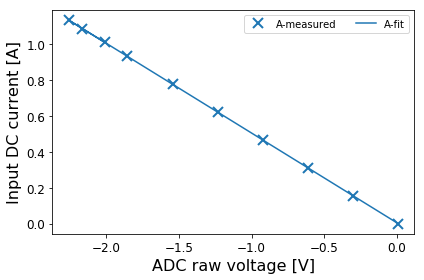

In [66]:
x_fit = v_adc #create array of values to plot the fit curves with

#evaluate each polynomial fit at each x point
yfit = np.polyval(P, x_fit)

#plot the linear fits over the experimental data
ax.plot(x_fit, yfit, c = 'C0', ls = '-', label = 'A-fit', zorder = -1)

ax.legend(ncol = 2) #recreate the legend with 2 columns
fig #call the figure object  to redisplay it. Note that just calling the figure like this is an artifact of jupyter notebooks.
    #in any other IDE, you would have to call fig.show() again to redisplay the figure.

We can see that the linear fits line up well with the data. If we wanted more information about our curve fits (like the correlation of our line, etc.) we could have used the curve fit functions built into scipy or scikit learn which would give us more information.